In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

import os
import sys

from tqdm import tqdm

import re

from PIL import Image
import requests

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = "/opt/ml/data/"

In [3]:
users = pd.read_csv(data_path + 'users.csv')
books = pd.read_csv(data_path + 'books.csv')
train = pd.read_csv(data_path + 'train_ratings.csv')
test = pd.read_csv(data_path + 'test_ratings.csv')

In [4]:
print('users shape: ', users.shape)
print('books shape: ', books.shape)
print('ratings shape: ', train.shape)

users shape:  (68092, 3)
books shape:  (149570, 10)
ratings shape:  (306795, 3)


In [5]:
def replace_na(unique:np.array):
    unique = unique.tolist()
    unique.remove('na')
    unique = ['na'] + unique
    return unique

def age_map(x: int) -> int:
    x = int(x)
    if x < 20:
        return 1
    elif x >= 20 and x < 30:
        return 2
    elif x >= 30 and x < 40:
        return 3
    elif x >= 40 and x < 50:
        return 4
    elif x >= 50 and x < 60:
        return 5
    else:
        return 6
    
ratings1 = train.copy() ; ratings2 = test.copy()

# user preprocessing
users['location'] = users['location'].str.replace(r'[^0-9a-zA-Z:,]', '') # 특수문자 제거
users['location_city'] = users['location'].apply(lambda x: x.split(',')[0])
users['location_state'] = users['location'].apply(lambda x: x.split(',')[1])
users['location_country'] = users['location'].apply(lambda x: x.split(',')[2])
users = users.replace('na', np.nan) #특수문자 제거로 n/a가 na로 바뀌게 되었습니다. 따라서 이를 컴퓨터가 인식할 수 있는 결측값으로 변환합니다.
users = users.replace('', np.nan) # 일부 경우 , , ,으로 입력된 경우가 있었으므로 이런 경우에도 결측값으로 변환합니다.

# city는 있는데 country 없는 경우 채우기
modify_location = users[(users['location_country'].isna())&(users['location_city'].notnull())]['location_city'].values

location_list = []
for location in tqdm(modify_location, desc='(1/4) fill country'):
    try:
        right_location = users[(users['location'].str.contains(location))&(users['location_country'].notnull())]['location'].value_counts().index[0]
        location_list.append(right_location)
    except:
        pass

for location in tqdm(location_list, desc='(2/4) fill city'):
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_state'] = location.split(',')[1]
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_country'] = location.split(',')[2]


# book preprocessing

# 유명 출판사 표기 오류로 그룹화되지 못하는 케이스 처리
publisher_dict=(books['publisher'].value_counts()).to_dict()
publisher_count_df = pd.DataFrame(list(publisher_dict.items()),columns = ['publisher','count'])
publisher_count_df = publisher_count_df.sort_values(by=['count'], ascending = False)

modify_list = publisher_count_df[publisher_count_df['count']>1].publisher.values

for publisher in tqdm(modify_list, desc = '(3/4) grouping same publisher'):
    try:
        number = books[books['publisher']==publisher]['isbn'].apply(lambda x: x[:4]).value_counts().index[0]
        right_publisher = books[books['isbn'].apply(lambda x: x[:4])==number]['publisher'].value_counts().index[0]
        books.loc[books[books['isbn'].apply(lambda x: x[:4])==number].index,'publisher'] = right_publisher
    except: 
        pass

# category 대괄호 제거 및 소문자 변환
books.loc[books[books['category'].notnull()].index, 'category'] = books[books['category'].notnull()]['category'].apply(lambda x: re.sub('[\W_]+',' ',x).strip())
books['category'] = books['category'].str.lower()

# 43개의 high-category로 묶기
categories = ['garden','crafts','physics','adventure','music','fiction','nonfiction','science','science fiction','social','homicide',
                'sociology','disease','religion','christian','philosophy','psycholog','mathemat','agricult','environmental',
                'business','poetry','drama','literary','travel','motion picture','children','cook','literature','electronic',
                'humor','animal','bird','photograph','computer','house','ecology','family','architect','camp','criminal','language','india']

for category in tqdm(categories, desc = '(4/4) : high-categorizing'):
    books.loc[books[books['category'].str.contains(category,na=False)].index,'category_high'] = category

# 10개 이하 항목 others로 묶기
category_high_df = pd.DataFrame(books['category_high'].value_counts()).reset_index()
category_high_df.columns = ['category','count']
others_list = category_high_df[category_high_df['count']<10]['category'].values
books.loc[books[books['category_high'].isin(others_list)].index, 'category_high']='others'

# year_of_publication 변수 전처리
books.loc[104259, 'year_of_publication'] = 2010.0
books.loc[121860, 'year_of_publication'] = 1997.0
books = books.drop(np.where(books['year_of_publication'] < 1900)[0][0]).reset_index(drop=True)

# location은 이제 필요 없음
users = users.drop(['location'], axis=1)
print('-'*20, 'Mission1 EDA Done', '-'*20)

ratings = pd.concat([ratings1, ratings2]).reset_index(drop=True)

# 인덱싱 처리된 데이터 조인
context_df = ratings.merge(users, on='user_id', how='left').merge(books[['isbn', 'category', 'category_high', 'publisher', 'language', 'book_author', 'year_of_publication']], on='isbn', how='left')
train_df = ratings1.merge(users, on='user_id', how='left').merge(books[['isbn', 'category', 'category_high', 'publisher', 'language', 'book_author', 'year_of_publication']], on='isbn', how='left')
test_df = ratings2.merge(users, on='user_id', how='left').merge(books[['isbn', 'category', 'category_high', 'publisher', 'language', 'book_author', 'year_of_publication']], on='isbn', how='left')

train_df['age'] = train_df['age'].fillna(int(train_df['age'].median()))
train_df['age_map'] = train_df['age'].apply(age_map)
test_df['age'] = test_df['age'].fillna(int(test_df['age'].median()))
test_df['age_map'] = test_df['age'].apply(age_map)

context_df = context_df.fillna('na') ; train_df = train_df.fillna('na') ; test_df = test_df.fillna('na')

(4/4) : high-categorizing: 100%|██████████| 43/43 [00:02<00:00, 19.22it/s]


-------------------- Mission1 EDA Done --------------------


In [6]:
train_df_copy = train_df.copy() ; test_df_copy = test_df.copy() ; context_df_copy = context_df.copy()

In [7]:
context_df_copy = context_df_copy.fillna('na') ; train_df_copy = train_df_copy.fillna('na') ; test_df_copy = test_df_copy.fillna('na')

# 인덱싱 처리
loc_city2idx = {v:k for k,v in enumerate(replace_na(context_df_copy['location_city'].unique()))}
loc_state2idx = {v:k for k,v in enumerate(replace_na(context_df_copy['location_state'].unique()))}
loc_country2idx = {v:k for k,v in enumerate(replace_na(context_df_copy['location_country'].unique()))}

train_df_copy['location_city'] = train_df_copy['location_city'].map(loc_city2idx)
train_df_copy['location_state'] = train_df_copy['location_state'].map(loc_state2idx)
train_df_copy['location_country'] = train_df_copy['location_country'].map(loc_country2idx)
test_df_copy['location_city'] = test_df_copy['location_city'].map(loc_city2idx)
test_df_copy['location_state'] = test_df_copy['location_state'].map(loc_state2idx)
test_df_copy['location_country'] = test_df_copy['location_country'].map(loc_country2idx)

# book 파트 인덱싱
category2idx = {v:k for k,v in enumerate(replace_na(context_df_copy['category'].unique()))}
categoryhigh2idx = {v:k for k,v in enumerate(replace_na(context_df_copy['category_high'].unique()))}
publisher2idx = {v:k for k,v in enumerate(replace_na(context_df_copy['publisher'].unique()))}
language2idx = {v:k for k,v in enumerate(replace_na(context_df_copy['language'].unique()))}
author2idx = {v:k for k,v in enumerate(replace_na(context_df_copy['book_author'].unique()))}

train_df_copy['category'] = train_df_copy['category'].map(category2idx)
train_df_copy['category_high'] = train_df_copy['category_high'].map(categoryhigh2idx)
train_df_copy['publisher'] = train_df_copy['publisher'].map(publisher2idx)
train_df_copy['language'] = train_df_copy['language'].map(language2idx)
train_df_copy['book_author'] = train_df_copy['book_author'].map(author2idx)
test_df_copy['category'] = test_df_copy['category'].map(category2idx)
test_df_copy['publisher'] = test_df_copy['publisher'].map(publisher2idx)
test_df_copy['language'] = test_df_copy['language'].map(language2idx)
test_df_copy['book_author'] = test_df_copy['book_author'].map(author2idx)

tree 모델의 경우 더미변수화가 필요 없지만 더미변수 중 일부를 추출했을 때 유의미한 피처로 작용할 수 있기 때문에 확인해보자.

그룹 별 boxplot 으로 확인해보면 좋을 듯 하며 때문에 100 개 이하의 고유의 값을 갖는 변수들만 확인해보자.

In [8]:
onehot_features = []

for col in train_df_copy.columns:
    print(f'# values of {col} : {train_df_copy[col].nunique()}')
    if train_df_copy[col].nunique() <= 100:
        if col in ['year_of_publication','rating', 'age']:    # age 와 year_of_publication 은 cat_features 로 작동X
            pass
        else:
            onehot_features.append(col)

# values of user_id : 59803
# values of isbn : 129777
# values of rating : 10
# values of age : 91
# values of location_city : 11130
# values of location_state : 1228
# values of location_country : 247
# values of category : 3716
# values of category_high : 41
# values of publisher : 1408
# values of language : 25
# values of book_author : 54716
# values of year_of_publication : 91
# values of age_map : 6


In [9]:
onehot_features 

['category_high', 'language', 'age_map']

### category_high

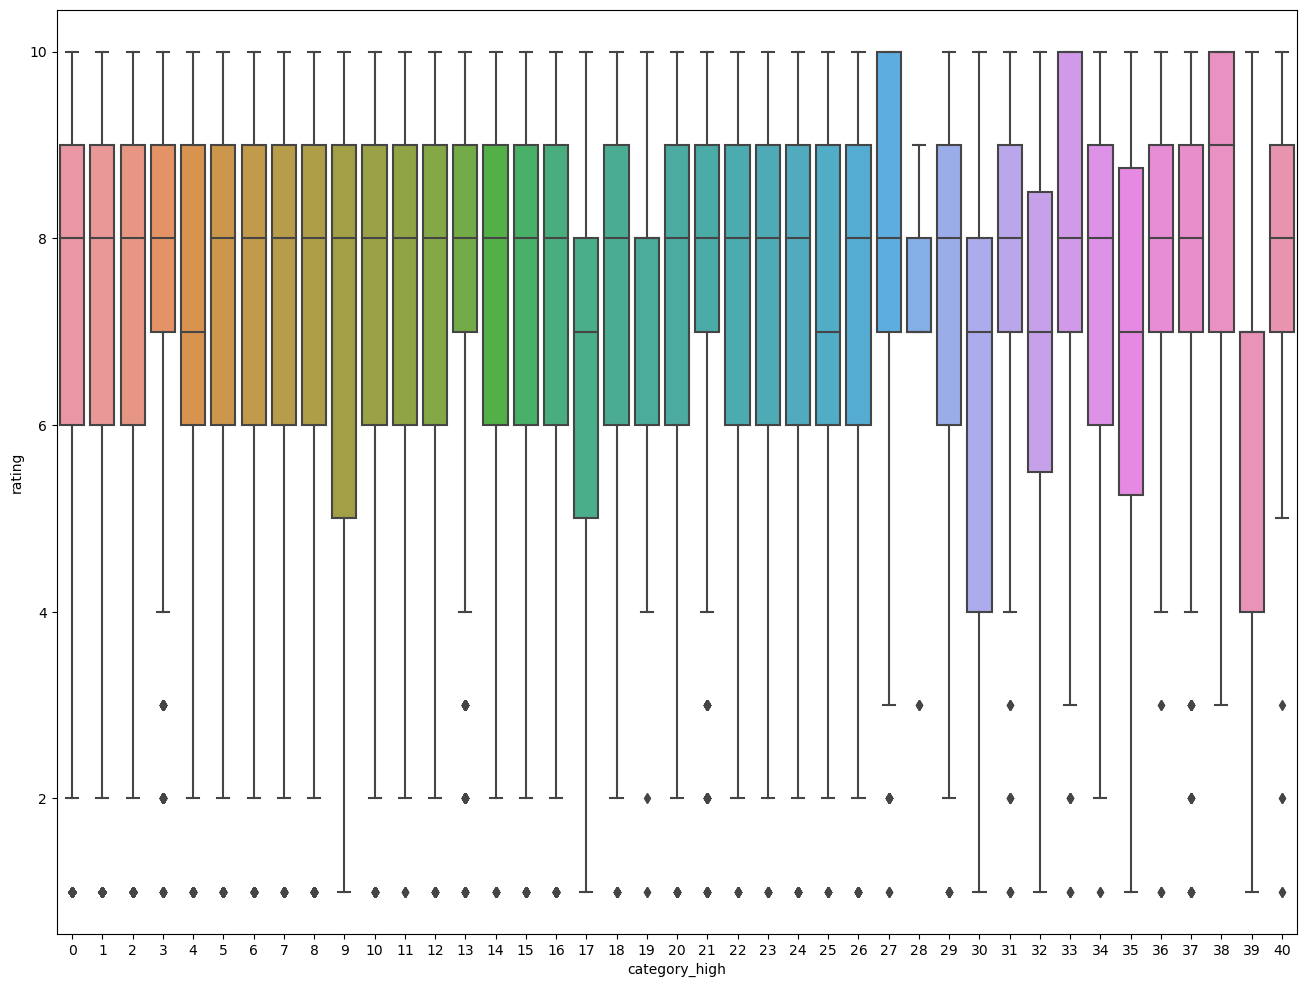

In [10]:
i = 0
plt.figure(figsize=(16,12))
sns.boxplot(x=f'{onehot_features[i]}', y='rating', data=train_df_copy)
plt.xlabel(f'{onehot_features[i]}')
plt.ylabel('rating')
plt.show()

category_high = [3,9,13,17,19,21,27,28,30,31,32,33,35,36,37,38,39,40] 의 경우 다른 값들과 분포가 상이함을 알 수 있다

따라서 해당 더미변수들을 추가하자

In [11]:
category_high_dummies = [3,9,13,17,19,21,27,28,30,31,32,33,35,36,37,38,39,40]

category_high_new_features = pd.get_dummies(train_df_copy['category_high'], prefix='category_high').iloc[:,category_high_dummies]
category_high_new_features

,category_high_3,category_high_9,category_high_13,category_high_17,category_high_19,category_high_21,category_high_27,category_high_28,category_high_30,category_high_31,category_high_32,category_high_33,category_high_35,category_high_36,category_high_37,category_high_38,category_high_39,category_high_40
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306790,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
306791,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
306792,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
306793,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### langauge

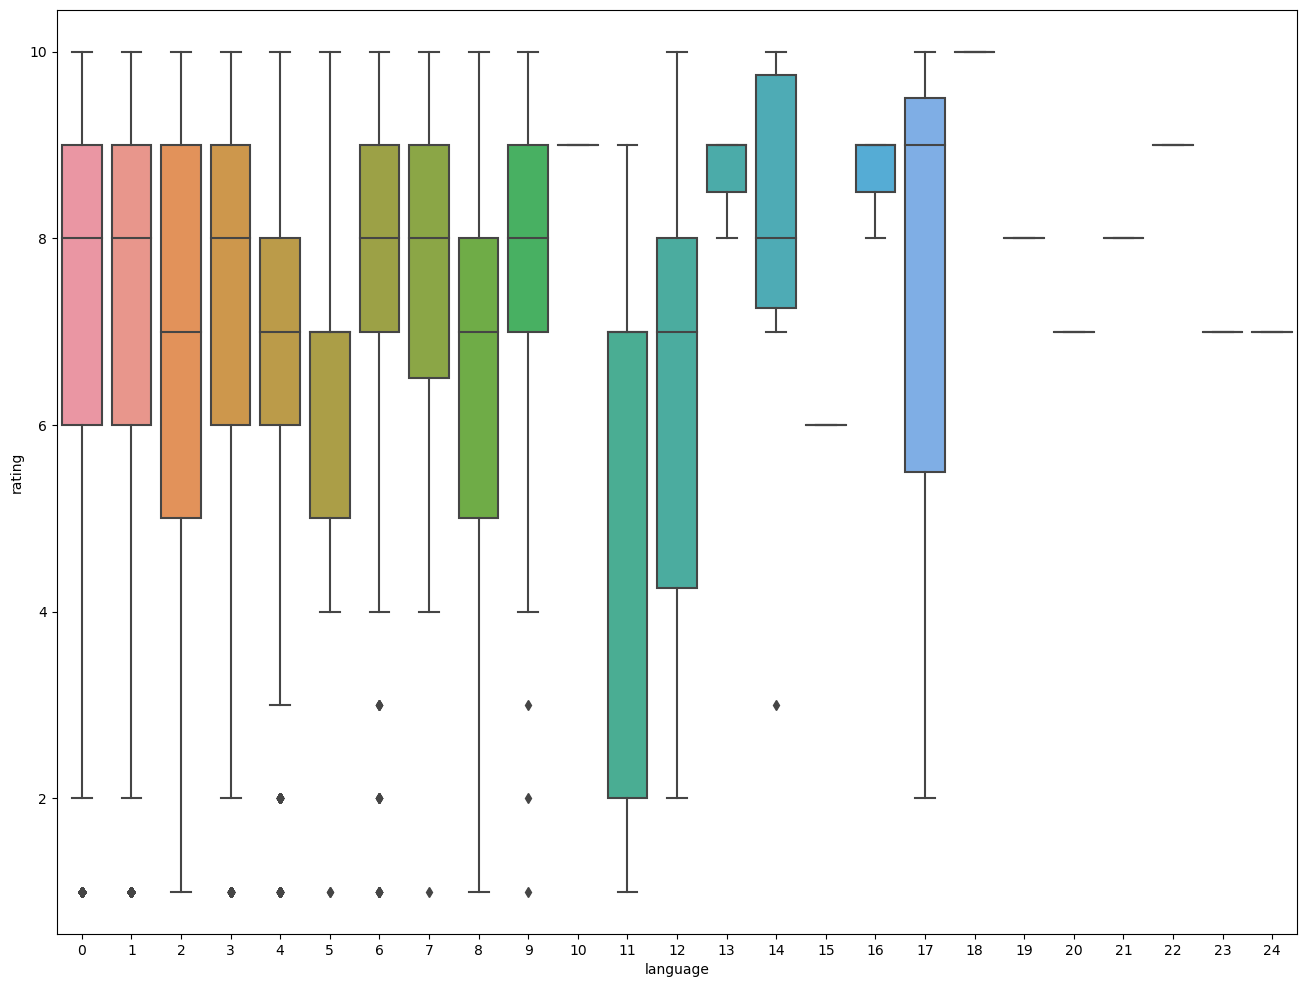

In [12]:
i = 1
plt.figure(figsize=(16,12))
sns.boxplot(x=f'{onehot_features[i]}', y='rating', data=train_df_copy)
plt.xlabel(f'{onehot_features[i]}')
plt.ylabel('rating')
plt.show()

language = [2,4,5,6,7,8,9,11,12,13,14,16,17] 의 경우 다른 값들과 분포가 상이함을 알 수 있다. 너무 sparse 한 값들은 제외하였다.

따라서 해당 더미변수들을 추가하자

In [13]:
lang_dummies = [2,4,5,6,7,8,9,11,12,13,14,16,17]

lang_new_features = pd.get_dummies(train_df_copy['language'], prefix='language').iloc[:,lang_dummies]
lang_new_features

,language_2,language_4,language_5,language_6,language_7,language_8,language_9,language_11,language_12,language_13,language_14,language_16,language_17
0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
306790,0,0,0,0,0,0,0,0,0,0,0,0,0
306791,0,0,0,0,0,0,0,0,0,0,0,0,0
306792,0,0,0,0,0,0,0,0,0,0,0,0,0
306793,0,0,0,0,0,0,0,0,0,0,0,0,0


### age_map

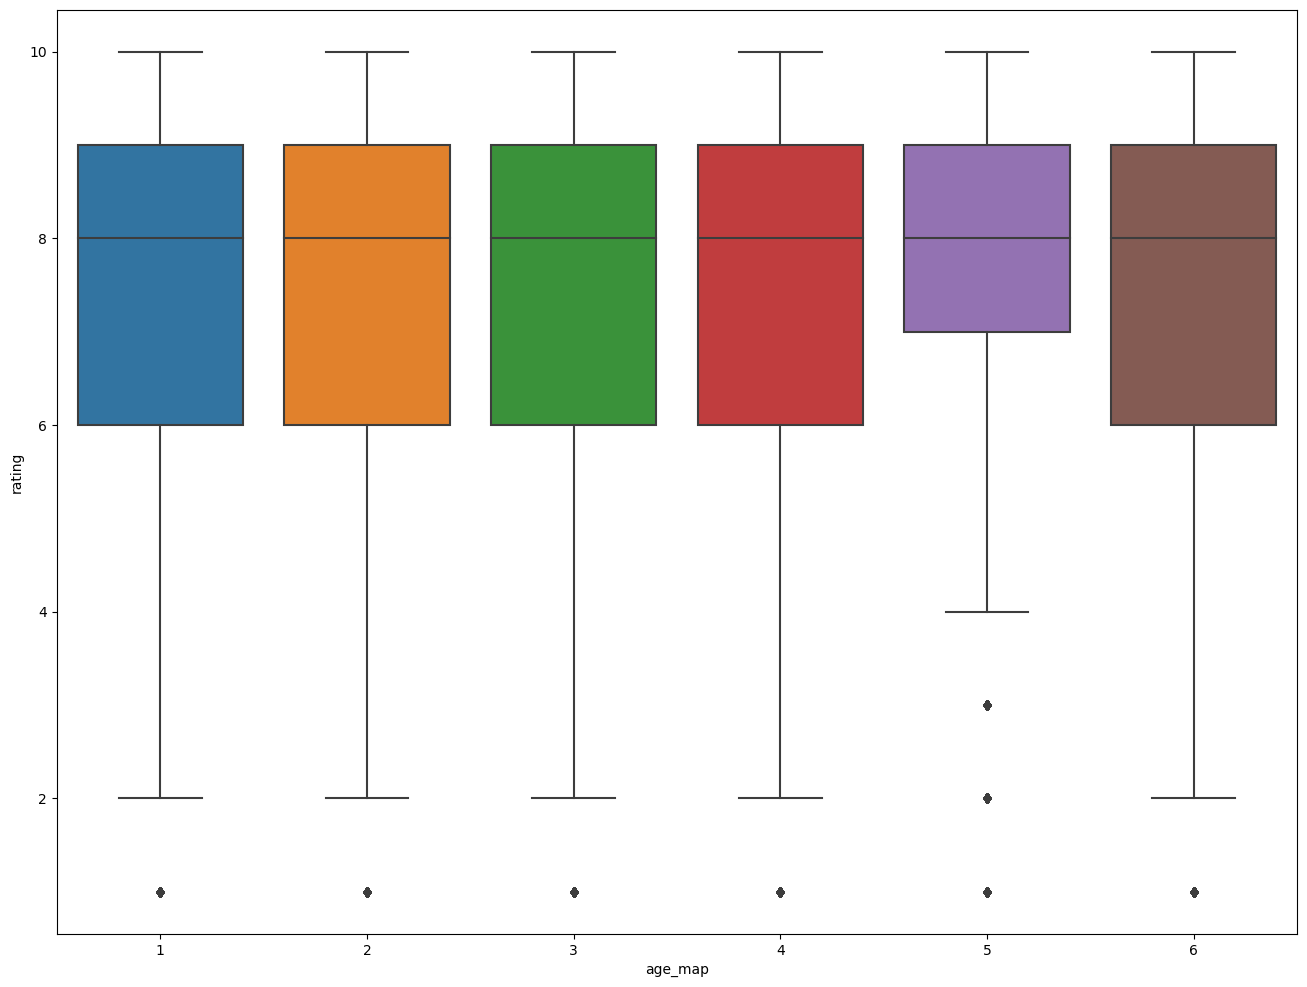

In [15]:
i = 2
plt.figure(figsize=(16,12))
sns.boxplot(x=f'{onehot_features[i]}', y='rating', data=train_df_copy)
plt.xlabel(f'{onehot_features[i]}')
plt.ylabel('rating')
plt.show()

'age_map' 변수가 5인 더미변수를 넣으면 좋을 듯함

In [24]:
age_map_new_features = pd.get_dummies(train_df_copy['age_map'], prefix='age_map')[['age_map_5']]
age_map_new_features

,age_map_5
0,0
1,0
2,0
3,0
4,0
...,...
306790,0
306791,0
306792,0
306793,0


최종적으로 만들어낸 피처들에서 1 의 비율을 확인해보고, 그 비율이 매우 적다면 해당 피처는 사용하지 않기로 하자.

In [ ]:
(category_high_new_features.apply(sum)/len(category_high_new_features) * 100).sort_values(ascending=False)[:5]

In [ ]:
(lang_new_features.apply(sum)/len(lang_new_features) * 100).sort_values(ascending=False)[:5]

In [ ]:
(age_map_new_features.apply(sum)/len(age_map_new_features) * 100).sort_values(ascending=False)[:5]

다들 비율이 많이 낮다... age_map_5 만 사용하자